# Joint Modeling end-to-end demo

Here we achieve the key goal of `blasé`: to make an end-to-end joint model for both the star and telluric spectrum.

In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
from blase.emulator import (SparseLinearEmulator, 
                            SparseLogEmulator, 
                            ExtrinsicModel,
                            InstrumentalModel)
import matplotlib.pyplot as plt
from gollum.phoenix import PHOENIXSpectrum
from gollum.telluric import TelFitSpectrum
import numpy as np
from tqdm.notebook import tqdm
import os

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Read in a precomputed synthetic stellar spectrum

In [3]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, wl_lo=10_800, wl_hi=11_500)
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

## Read in a precomputed synthetic telluric spectrum

In [4]:
fn = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp270_hum055.txt'

In [5]:
telluric_spectrum_full = TelFitSpectrum(path=fn)

In [6]:
mask = (telluric_spectrum_full.wavelength.value > 10_800) & (telluric_spectrum_full.wavelength.value < 11_500)

In [7]:
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

Trim to a smaller wavelength range

(10880.0, 10980.0)

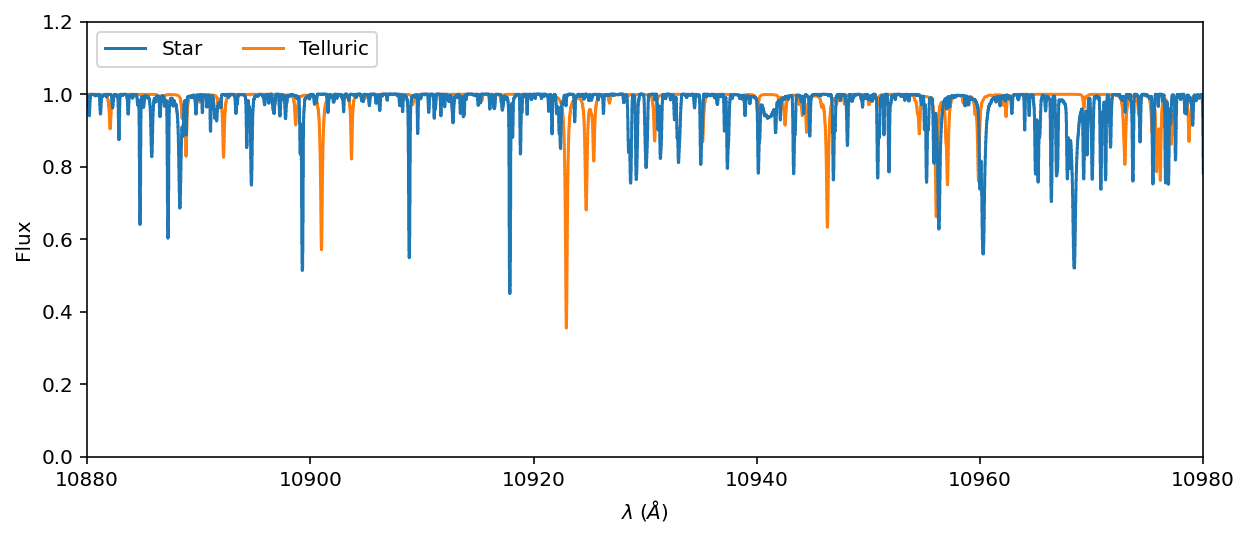

In [8]:
ax = stellar_spectrum.plot(ylo=0, label='Star');
telluric_spectrum.plot(ax=ax, zorder=0, label='Telluric')
plt.legend(ncol=2, loc='upper left');
ax.set_xlim(10880, 10980)
#ax.set_xlim(11_200.5, 11_250)

Great! Let's clone the telluric spectrum with the LogEmulator.

In [9]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = telluric_spectrum.flux.value
telluric_flux = np.abs(telluric_flux)
telluric_lnflux = np.log(telluric_flux)

Below about -15 in log space, the flux becomes dominated by numerical artifacts.  That's okay, we will never perceive flux that is less than a ten-millionth of the continuum, so we can simply chop it off.  

In [10]:
telluric_lnflux[telluric_lnflux < -15] = -15

In [11]:
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, wing_cut_pixels=6000, prominence=0.01)

Initializing a sparse model with 536 spectral lines


In [12]:
with torch.no_grad():
    telluric_clone = emulator.forward().numpy()

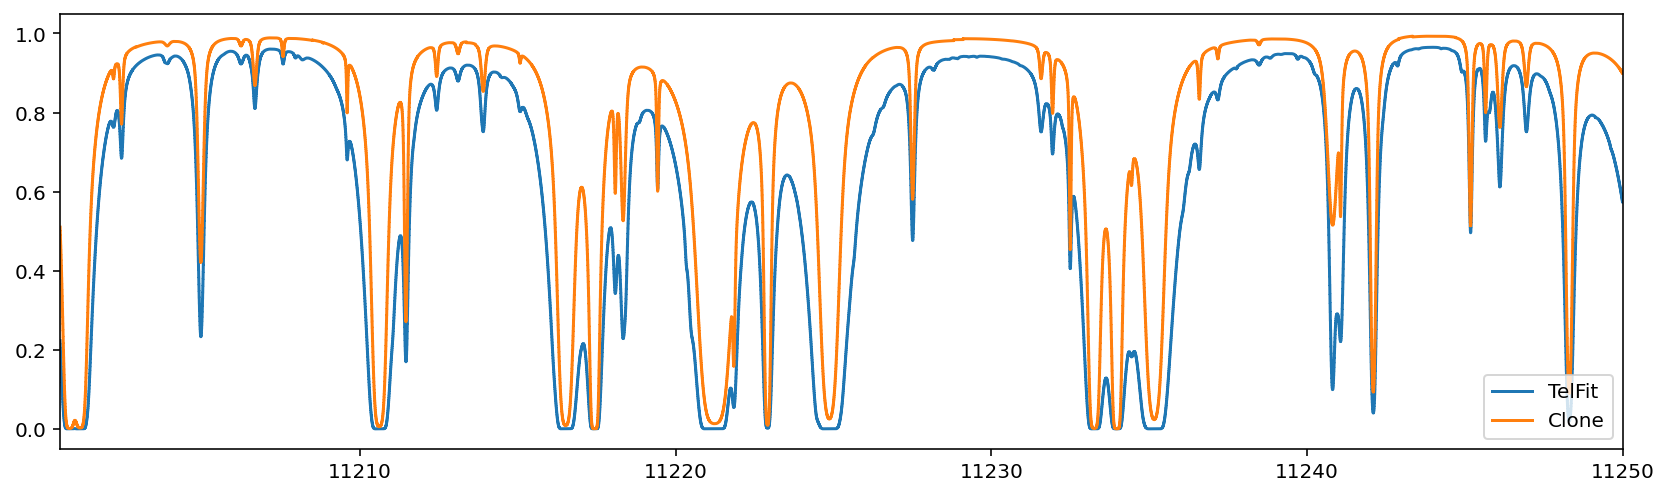

In [13]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux, label='TelFit')
plt.step(telluric_wl, telluric_clone, label='Clone')
plt.xlim(11_200.5, 11_250)
plt.legend(loc='lower right');

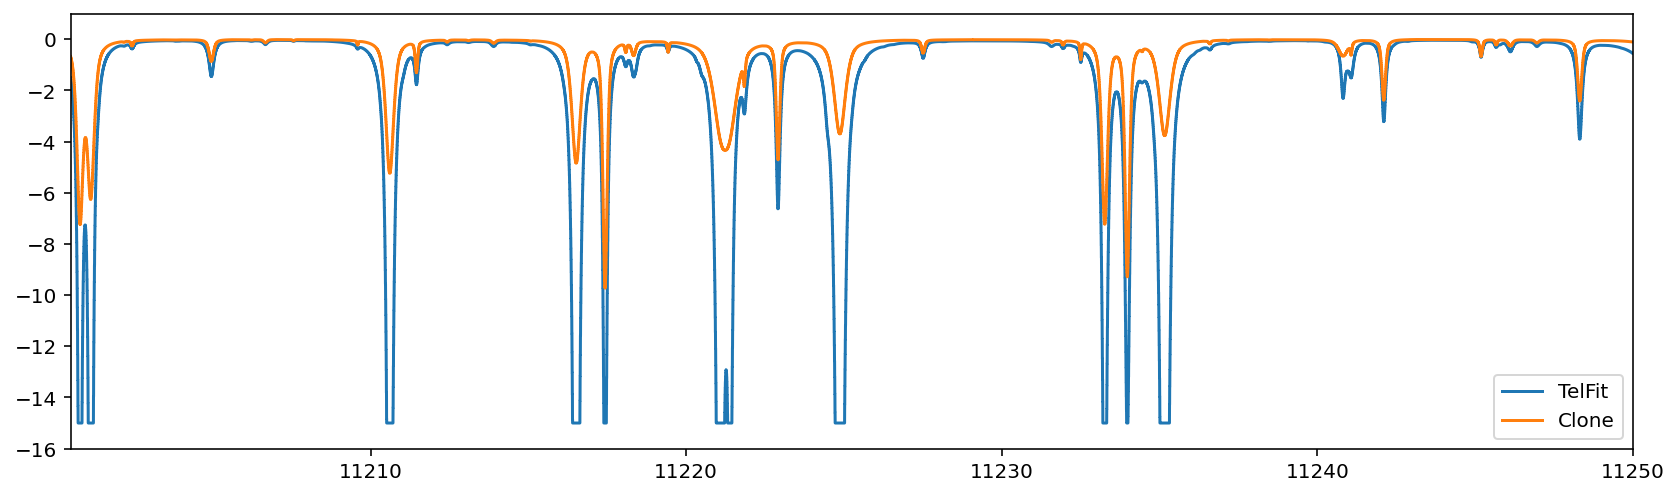

In [14]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_lnflux, label='TelFit')
plt.step(telluric_wl, np.log(telluric_clone), label='Clone')
plt.xlim(11_200.5, 11_250)
plt.ylim(-16, 1)
plt.legend(loc='lower right');

## Train the emulator.

In [15]:
from torch import nn
import torch.optim as optim
from tqdm import trange

In [16]:
emulator.lam_centers.requires_grad = False
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

In [17]:
target = torch.tensor(telluric_flux)

In [18]:
loss_fn = nn.MSELoss(reduction="sum")

optimizer = optim.Adam(filter(lambda p: p.requires_grad, emulator.parameters()),
    0.02,
    amsgrad=True,
)
n_epochs = 100
losses = []

In [19]:
t_iter = trange(n_epochs, desc="Training", leave=True)
for epoch in t_iter:
    emulator.train()
    high_res_model = emulator.forward()
    loss = loss_fn(target, high_res_model)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    t_iter.set_description("Training Loss: {:0.8f}".format(loss.item()))

Training Loss: 2005.41443472: 100%|███████████| 100/100 [03:38<00:00,  2.19s/it]


In [20]:
with torch.no_grad():
    telluric_post = emulator.forward().numpy()

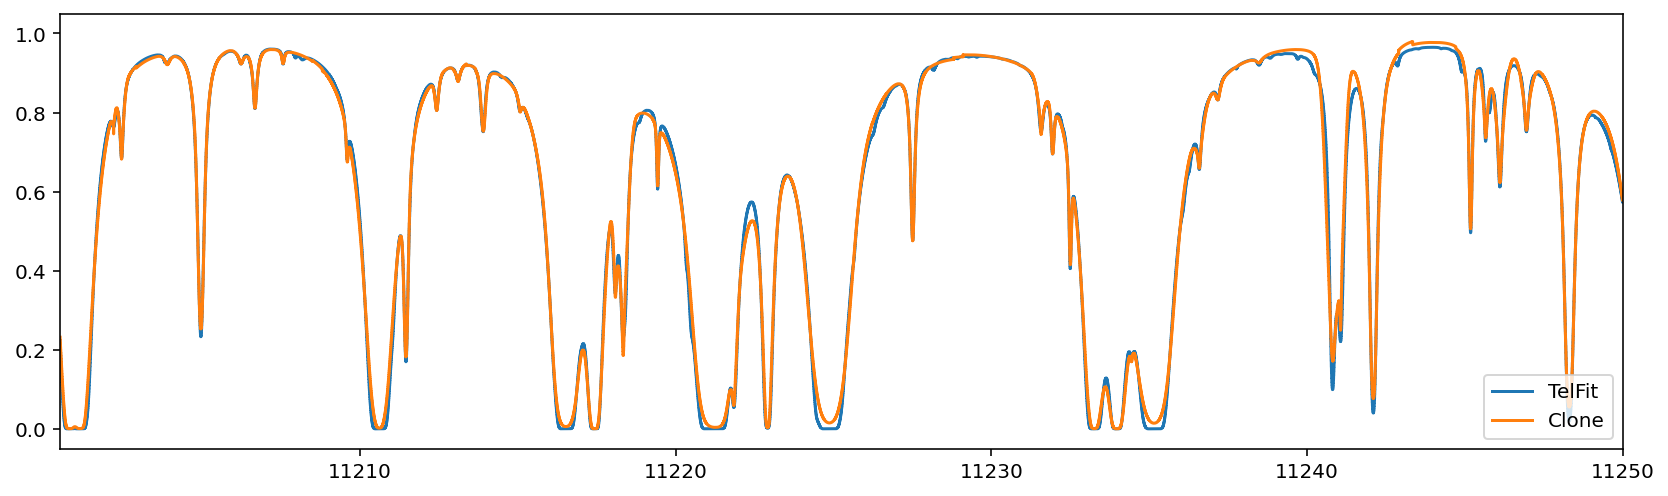

In [21]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux, label='TelFit')
plt.step(telluric_wl, telluric_post, label='Clone')
plt.xlim(11_200.5, 11_250)
plt.legend(loc='lower right');

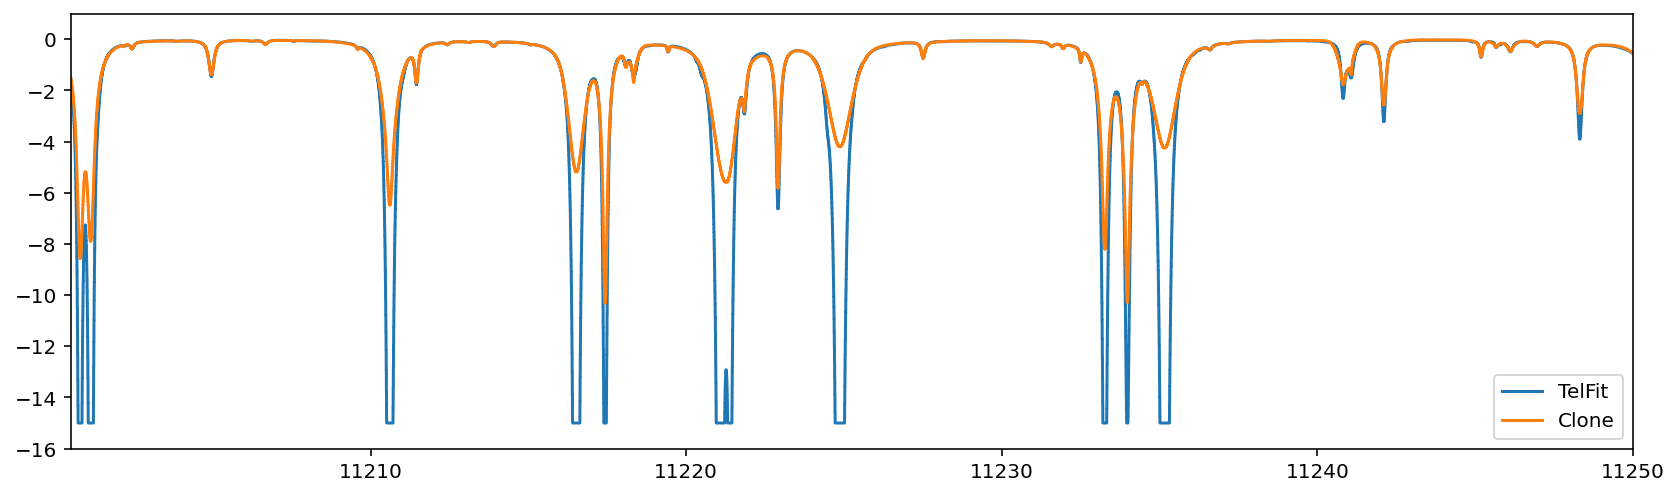

In [22]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_lnflux, label='TelFit')
plt.step(telluric_wl, np.log(telluric_post), label='Clone')
plt.xlim(11_200.5, 11_250)
plt.ylim(-16, 1)
plt.legend(loc='lower right');

In [30]:
residual = telluric_flux-telluric_post

In [34]:
residual_mask = (telluric_wl >10_850) & (telluric_wl<11450)

In [35]:
residual=residual[residual_mask]

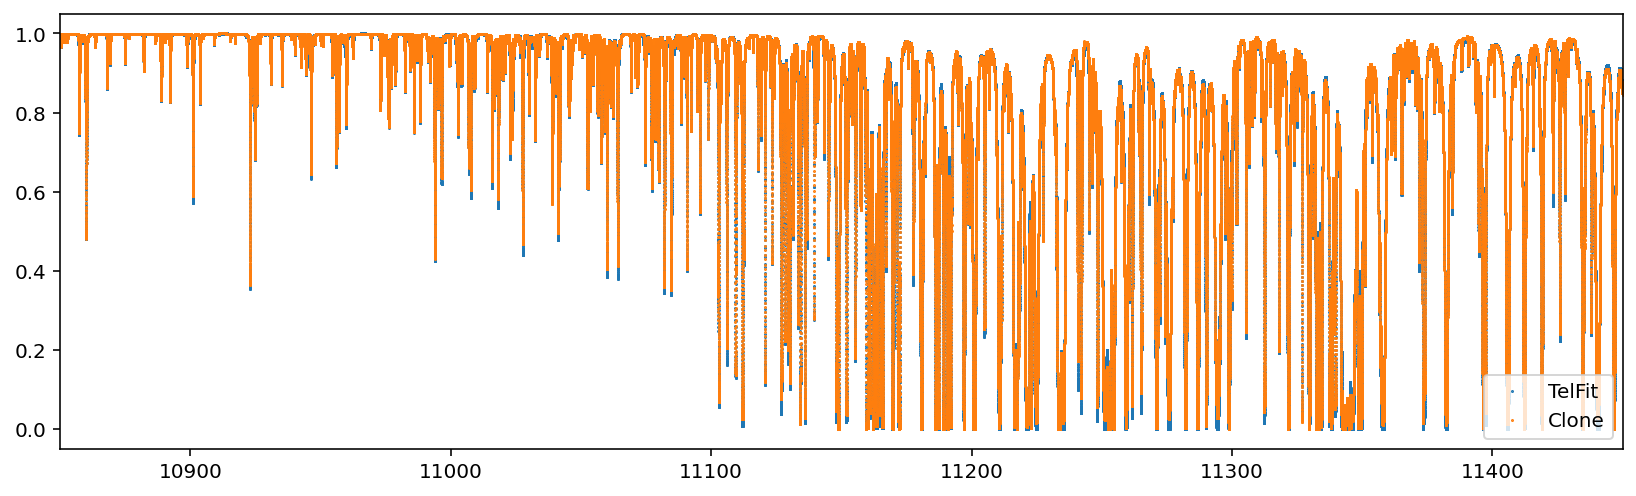

In [40]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux, '.',ms=1, label='TelFit')
plt.step(telluric_wl, telluric_post, '.',ms=1, label='Clone')
plt.xlim(10_850, 11450)
plt.legend(loc='lower right');

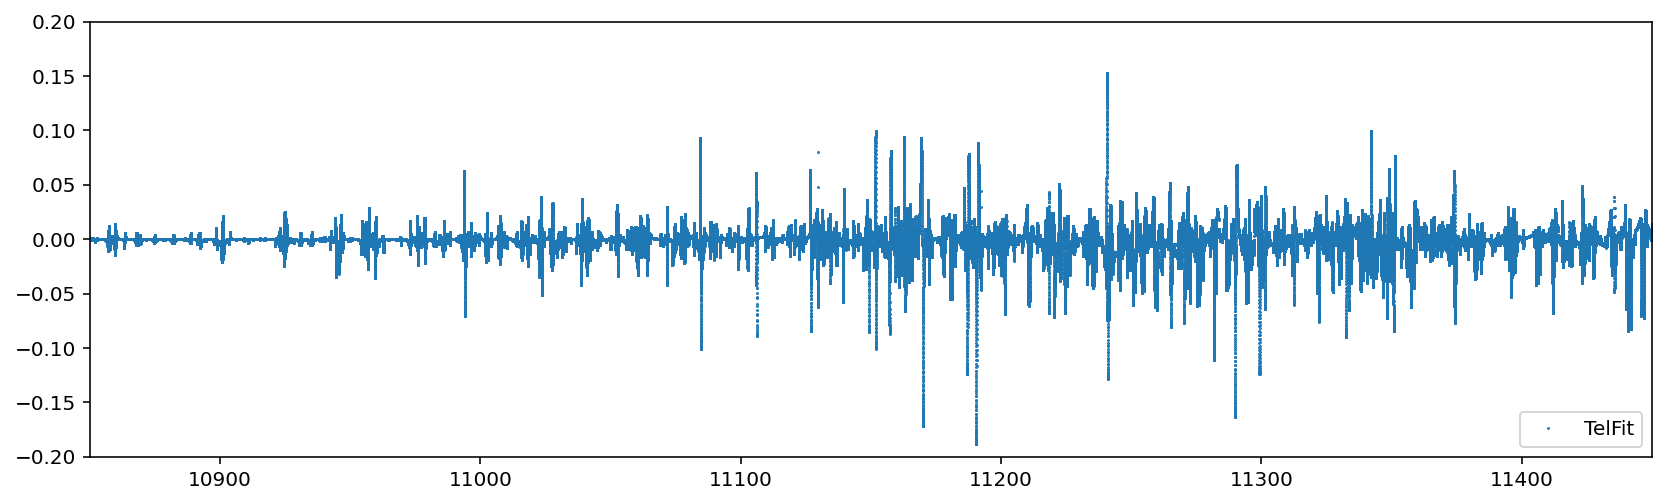

In [28]:
plt.figure(figsize=(14,4))
plt.step(telluric_wl, telluric_flux-telluric_post, '.',ms=1, label='TelFit')
plt.xlim(10_850, 11450)
plt.ylim(-0.2, 0.2)
plt.legend(loc='lower right');

In [38]:
np.std(telluric_flux)/np.std(residual)

18.77733760864773

In [39]:
np.std(residual)

0.014717409908851687

## Clone the stellar model